In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

## load time series data

In [2]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

## time series data without anomalies

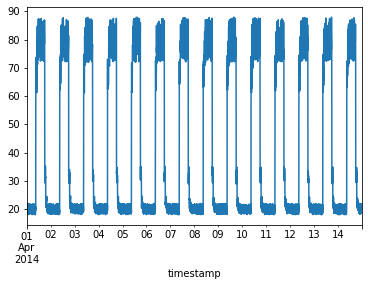

In [3]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

## time series data with anomalies

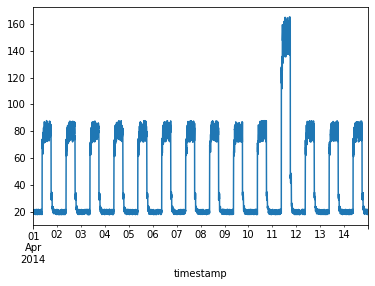

In [4]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

## prepare training data

In [5]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))
print(f'Shape of data: {df_training_value.values.shape}')

Number of training samples: 4032
Shape of data: (4032, 1)


## create sequences

In [6]:
def create_sequences(values, time_steps=288):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [7]:
x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3744, 288, 1)


## create a autoencoder model

In [8]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 144, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 144, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 144, 16)           1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 288, 1)            2

## train the model

In [9]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 3s 87ms/step - loss: 0.7373 - val_loss: 0.1077
Epoch 2/50
27/27 [==============================] - 1s 55ms/step - loss: 0.0983 - val_loss: 0.0411
Epoch 3/50
27/27 [==============================] - 1s 47ms/step - loss: 0.0597 - val_loss: 0.0322
Epoch 4/50
27/27 [==============================] - 1s 51ms/step - loss: 0.0467 - val_loss: 0.0280
Epoch 5/50
27/27 [==============================] - 1s 49ms/step - loss: 0.0392 - val_loss: 0.0231
Epoch 6/50
27/27 [==============================] - 1s 48ms/step - loss: 0.0342 - val_loss: 0.0218
Epoch 7/50
27/27 [==============================] - 1s 52ms/step - loss: 0.0312 - val_loss: 0.0212
Epoch 8/50
27/27 [==============================] - 1s 50ms/step - loss: 0.0289 - val_loss: 0.0199
Epoch 9/50
27/27 [==============================] - 1s 51ms/step - loss: 0.0272 - val_loss: 0.0192
Epoch 10/50
27/27 [==============================] - 1s 50ms/step - loss: 0.0257 - val_loss: 0.0181
Epoch 11/

## training and validation loss

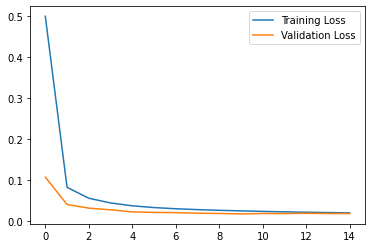

In [10]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## detecting anomalies

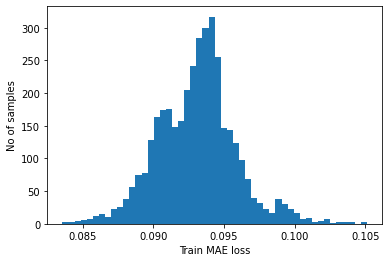

Reconstruction error threshold:  0.10511325261956402


In [11]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

## verify our reconstructed input

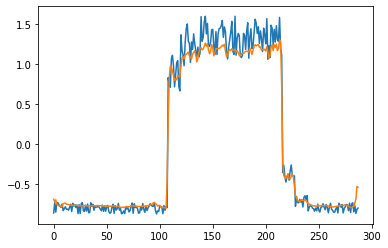

In [12]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

## prepare test (unseen data)

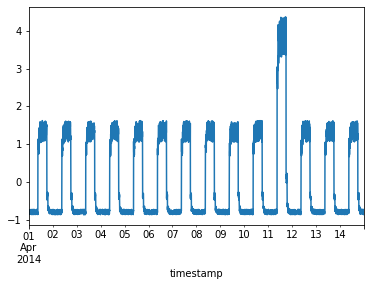

Test input shape:  (3744, 288, 1)


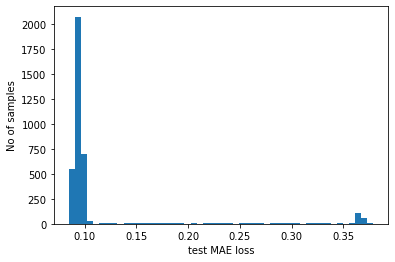

Number of anomaly samples:  400
Indices of anomaly samples:  (array([ 788, 1652, 2522, 2523, 2695, 2698, 2702, 2703, 2704, 2705, 2706,
       2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717,
       2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728,
       2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739,
       2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750,
       2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761,
       2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772,
       2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783,
       2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794,
       2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805,
       2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816,
       2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827,
       2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2

In [13]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

## plot anomal samples

In [14]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
TIME_STEPS = 288
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

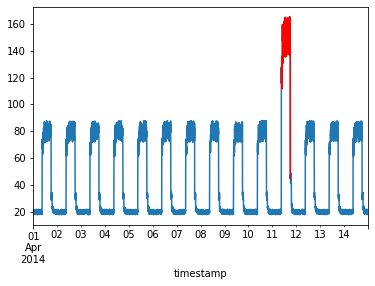

In [15]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()